In [5]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label, generate_binary_structure
from scipy.stats import ttest_ind, ttest_1samp
import re
from tqdm import tqdm
import glob

# Define paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'  # Make sure to use the appropriate sub_info file
output_dir = f'{results_dir}/gca_quantitative_exp1'
os.makedirs(output_dir, exist_ok=True)

In [7]:
# Cell 2: Load thresholded GCA images
def load_thresholded_images():
    """Load previously thresholded GCA images for experiment 1"""
    thresholded_imgs = {}
    
    # Define the directory containing the thresholded GCA images
    gca_dir = f'{results_dir}/group_averages/gca_group_averages'
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load each file
    for roi in rois:
        for hemi in hemispheres:
            img_path = f'{gca_dir}/{roi}_{hemi}_gca_thresh.nii.gz'
            if os.path.exists(img_path):
                thresholded_imgs[f"{roi}_{hemi}"] = nib.load(img_path)
            else:
                print(f"Warning: {img_path} not found")
    
    return thresholded_imgs

thresholded_imgs = load_thresholded_images()
print(f"Loaded {len(thresholded_imgs)} thresholded GCA images")

Loaded 4 thresholded GCA images


In [8]:
# Cell 3: Load and apply merged atlas to GCA results
def load_merged_atlas():
    """Load the merged Schaefer-Wang atlas"""
    atlas_path = f'{results_dir}/schaefer_wang_merged.nii.gz'
    labels_path = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(atlas_path) or not os.path.exists(labels_path):
        print("Error: Merged atlas files not found!")
        return None, None
    
    atlas_img = nib.load(atlas_path)
    labels = np.load(labels_path, allow_pickle=True)
    
    print(f"Loaded merged atlas with {len(labels)} regions")
    return atlas_img, labels

def extract_roi_values(thresholded_imgs, atlas_img, atlas_labels):
    """Extract values from thresholded GCA images for each ROI in the merged atlas"""
    atlas_data = atlas_img.get_fdata()
    
    # Create a dictionary to store results
    roi_values = {}
    
    # Process each thresholded image
    for img_key, img in thresholded_imgs.items():
        img_data = img.get_fdata()
        
        # Initialize a dictionary for this image
        roi_values[img_key] = {}
        
        # Extract values for each ROI in the atlas
        for i in range(len(atlas_labels)):
            roi_value = i + 1  # ROI values in atlas start from 1
            roi_mask = atlas_data == roi_value
            
            # Extract values from the GCA image within this ROI
            if np.any(roi_mask):
                values = img_data[roi_mask]
                roi_values[img_key][i] = values
        
        # Also process Wang ROIs (pIPS and LO)
        wang_rois = {'pIPS': 201, 'LO': 202}
        for roi_name, roi_value in wang_rois.items():
            roi_mask = atlas_data == roi_value
            if np.any(roi_mask):
                values = img_data[roi_mask]
                roi_values[img_key][roi_name] = values
    
    return roi_values

# Load merged atlas
atlas_img, atlas_labels = load_merged_atlas()

# Extract ROI values from thresholded images
roi_values = extract_roi_values(thresholded_imgs, atlas_img, atlas_labels)

Loaded merged atlas with 202 regions



CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS
Using LOOV and Bootstrapping (10 iterations)
Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...
Found 4 seed keys: ['pIPS_left', 'pIPS_right', 'LO_left', 'LO_right']
Processing pIPS (averaging L and R hemispheres)...
  Running bootstrap for ROI 0...
  Running bootstrap for ROI 1...
  Running bootstrap for ROI 2...
  Running bootstrap for ROI 3...
  Running bootstrap for ROI 4...
  Running bootstrap for ROI 5...
  Running bootstrap for ROI 6...
  Running bootstrap for ROI 7...
  Running bootstrap for ROI 8...
  Running bootstrap for ROI 9...
  Running bootstrap for ROI 10...
  Running bootstrap for ROI 11...
  Running bootstrap for ROI 12...
  Running bootstrap for ROI 13...
  Running bootstrap for ROI 14...
  Running bootstrap for ROI 15...
  Running bootstrap for ROI 16...
  Running bootstrap for ROI 17...
  Running bootstrap for ROI 18...
  Running bootstrap for ROI 19...
  Running bo

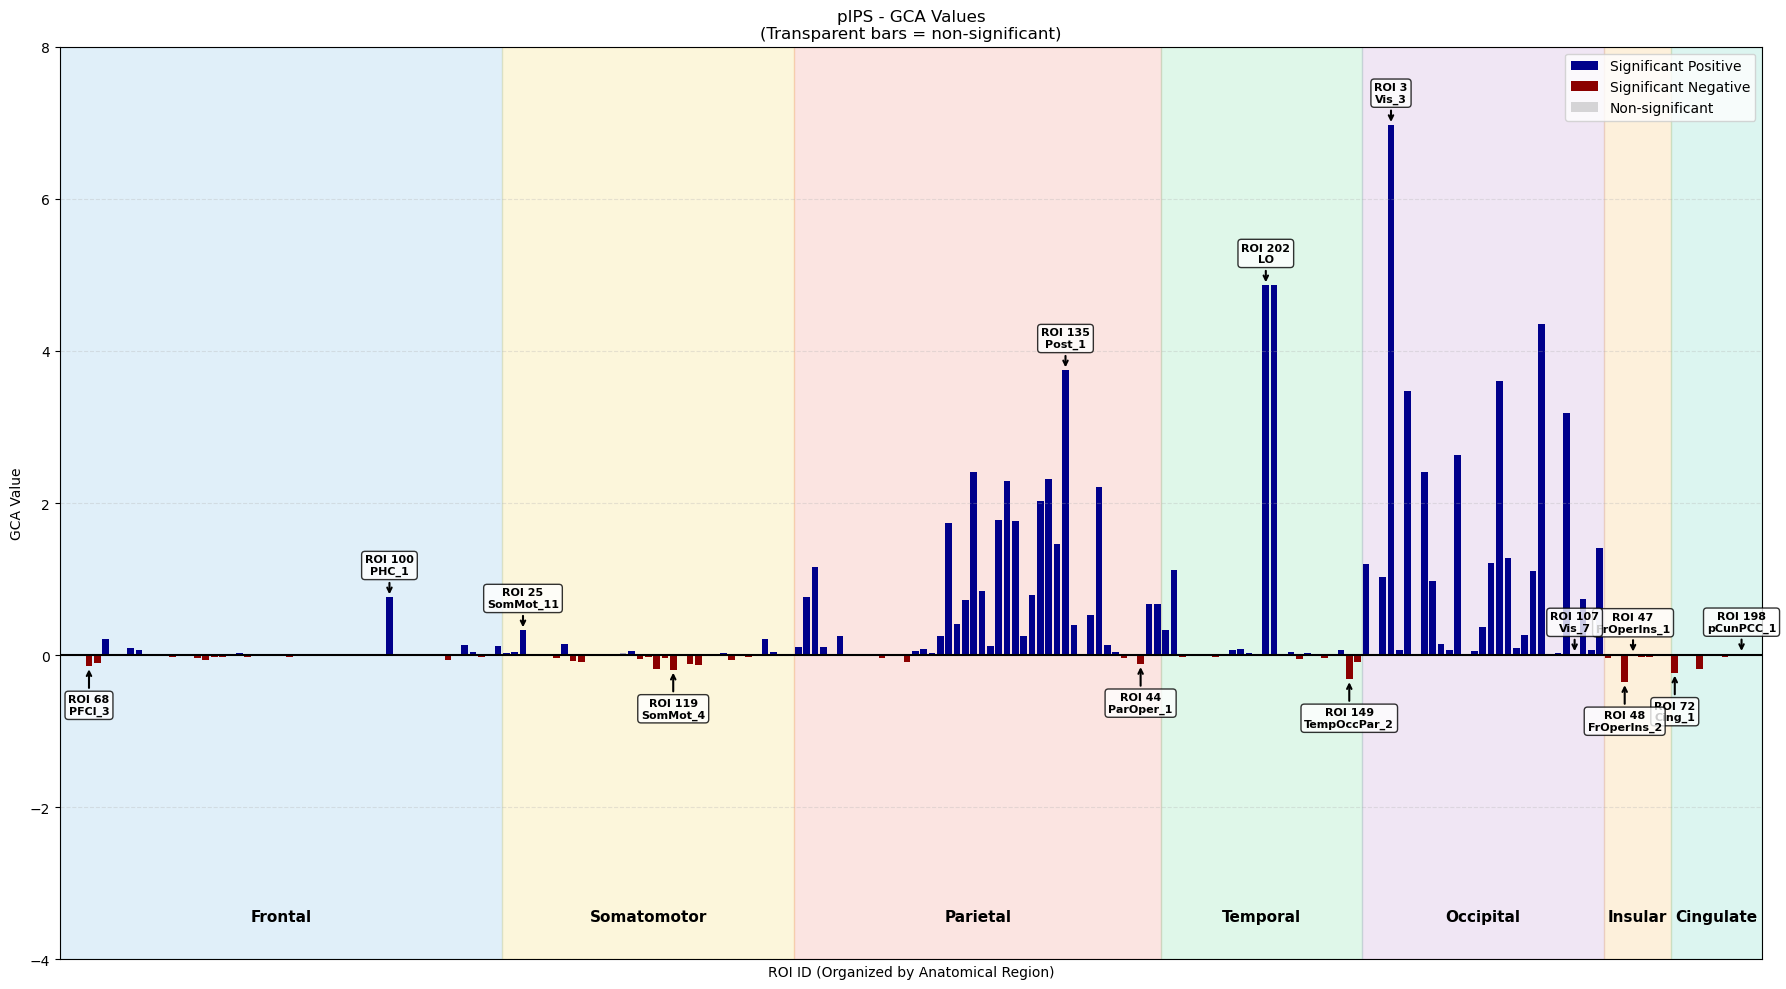

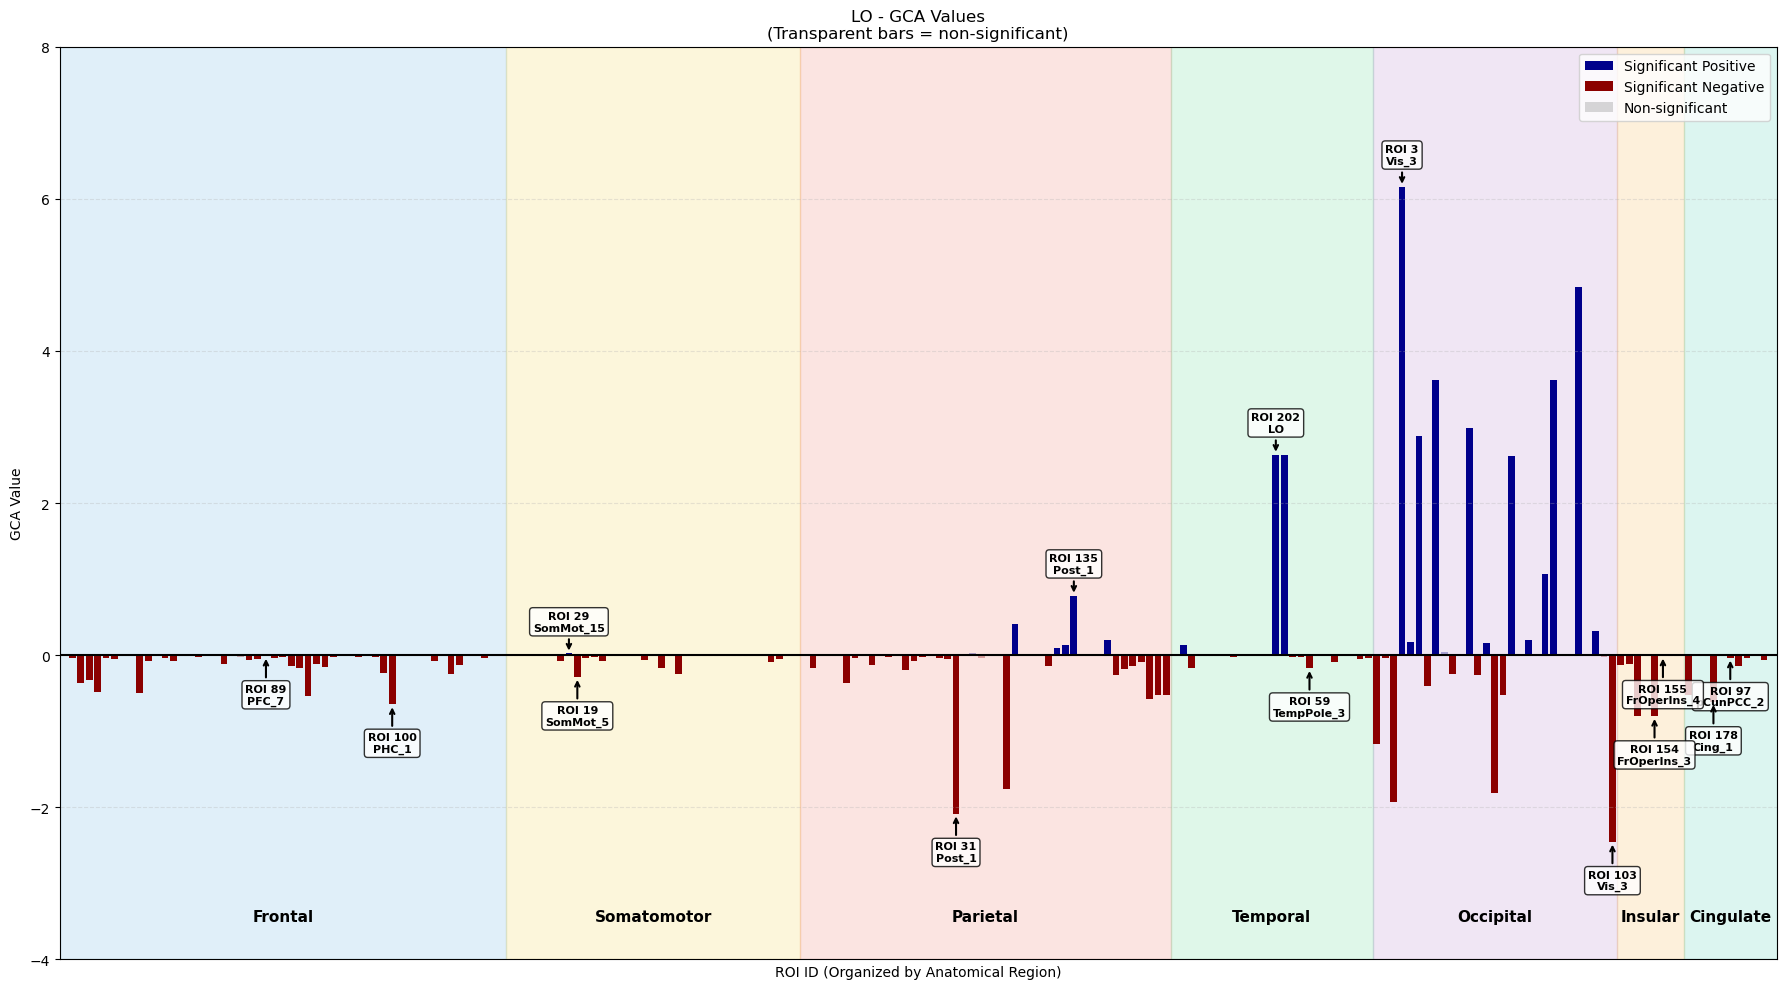

In [13]:
# Cell 4: Enhanced GCA bar plots with anatomical organization, LOOV, and bootstrapping
def plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10):
    """Create anatomical organization visualization for GCA data with LOOV and bootstrapping"""
    print(f"\n{'='*80}")
    print(f"CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS")
    print(f"Using LOOV and Bootstrapping ({bootstrap_iterations} iterations)")
    print(f"{'='*80}")
    
    # Create output directory
    bar_plot_dir = os.path.join(output_dir, 'gca_anatomical')
    os.makedirs(bar_plot_dir, exist_ok=True)
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Perform bootstrapping on a set of values
    def bootstrap_analysis(values, n_iterations=10, confidence=0.95):
        if len(values) < 2:
            return np.nan, np.nan, np.nan
        
        # Initialize storage for bootstrap means
        bootstrap_means = np.zeros(n_iterations)
        
        # Perform bootstrap iterations
        for i in range(n_iterations):
            # Sample with replacement
            sample = np.random.choice(values, size=len(values), replace=True)
            bootstrap_means[i] = np.mean(sample)
        
        # Sort bootstrap means for confidence interval calculation
        bootstrap_means = np.sort(bootstrap_means)
        
        # Calculate confidence intervals
        lower_bound_idx = int((1 - confidence) / 2 * n_iterations)
        upper_bound_idx = int((1 - (1 - confidence) / 2) * n_iterations)
        
        # Return mean and CI
        return np.mean(values), bootstrap_means[lower_bound_idx], bootstrap_means[upper_bound_idx-1]
    
    # Perform Leave-One-Out Validation
    def loov_analysis(values):
        if len(values) < 2:
            return np.nan, np.nan
        
        # Storage for leave-one-out means
        loo_means = np.zeros(len(values))
        
        # Leave one out at a time
        for i in range(len(values)):
            # Create mask excluding current item
            mask = np.ones(len(values), dtype=bool)
            mask[i] = False
            
            # Calculate mean excluding current item
            loo_means[i] = np.mean(values[mask])
        
        # Return mean of LOO means and standard deviation
        return np.mean(loo_means), np.std(loo_means)
    
    # Filter and group data by seed roi
    print("Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...")
    
    # Group keys by seed
    grouped_data = {}
    seed_keys = []
    
    # First, find all keys for pIPS and LO
    for img_key in roi_values.keys():
        seed_roi, hemi = img_key.split('_')
        
        # Filter for pIPS and LO seeds
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = f"{seed_roi}"
            if group_key not in grouped_data:
                grouped_data[group_key] = {'left': None, 'right': None}
            
            grouped_data[group_key][hemi] = img_key
            seed_keys.append(img_key)
    
    print(f"Found {len(seed_keys)} seed keys: {seed_keys}")
    
    # Create structure to store raw subject values for bootstrapping
    subject_values = {}
    
    # Now process each seed group, averaging left and right hemispheres
    for group_key, hemi_keys in grouped_data.items():
        seed_roi = group_key
        
        # Skip if we don't have both hemispheres
        if hemi_keys['left'] is None or hemi_keys['right'] is None:
            print(f"Skipping {group_key} - missing one hemisphere")
            continue
        
        print(f"Processing {group_key} (averaging L and R hemispheres)...")
        
        # Collect and average data for all ROIs across both hemispheres
        combined_roi_data = {}
        subject_values[group_key] = {}
        
        # Process left hemisphere
        for roi_id in roi_values[hemi_keys['left']]:
            values_L = roi_values[hemi_keys['left']][roi_id]
            values_L = values_L[~np.isnan(values_L) & ~np.isinf(values_L)]
            
            if len(values_L) > 0:
                combined_roi_data[roi_id] = {'L': values_L, 'R': None}
                subject_values[group_key][roi_id] = []
        
        # Process right hemisphere
        for roi_id in roi_values[hemi_keys['right']]:
            values_R = roi_values[hemi_keys['right']][roi_id]
            values_R = values_R[~np.isnan(values_R) & ~np.isinf(values_R)]
            
            if len(values_R) > 0:
                if roi_id in combined_roi_data:
                    combined_roi_data[roi_id]['R'] = values_R
                else:
                    combined_roi_data[roi_id] = {'L': None, 'R': values_R}
                    subject_values[group_key][roi_id] = []
        
        # Create data for plotting
        roi_data = []
        
        # Average values for each ROI and perform statistics
        for roi_id, hemi_values in combined_roi_data.items():
            # Get ROI name
            if isinstance(roi_id, int):
                roi_name = atlas_labels[roi_id]
                if isinstance(roi_name, bytes):
                    roi_name = roi_name.decode('utf-8')
            else:
                # It's a Wang ROI
                roi_name = f"Wang_{roi_id}"
            
            # Combine L and R values if both exist
            if hemi_values['L'] is not None and hemi_values['R'] is not None:
                # Calculate the mean value for each subject by averaging L and R values
                if len(hemi_values['L']) == len(hemi_values['R']):
                    # If same number of samples, assume they are aligned
                    combined_values = (hemi_values['L'] + hemi_values['R']) / 2
                else:
                    # If different number of samples, concatenate
                    combined_values = np.concatenate([hemi_values['L'], hemi_values['R']])
            elif hemi_values['L'] is not None:
                combined_values = hemi_values['L']
            elif hemi_values['R'] is not None:
                combined_values = hemi_values['R']
            else:
                continue  # Skip if no values
            
            # Store combined values for bootstrapping
            subject_values[group_key][roi_id] = combined_values
            
            # Get basic statistics
            mean_value = np.mean(combined_values)
            
            # Perform t-test if possible
            if len(combined_values) > 1 and np.var(combined_values) > 0:
                t_stat, p_value = ttest_1samp(combined_values, 0)
                is_significant = p_value < 0.05
            else:
                t_stat, p_value = np.nan, np.nan
                is_significant = False
            
            # Perform LOOV analysis
            loov_mean, loov_std = loov_analysis(combined_values)
            
            # Perform bootstrap analysis
            print(f"  Running bootstrap for ROI {roi_id}...")
            bootstrap_mean, bootstrap_ci_lower, bootstrap_ci_upper = bootstrap_analysis(
                combined_values, n_iterations=bootstrap_iterations)
            
            # Add to data list
            roi_data.append({
                'ROI_ID': roi_id + 1 if isinstance(roi_id, int) else roi_id,  # Make 1-indexed for display
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Value': mean_value,
                't_stat': t_stat,
                'p_value': p_value,
                'Significant': is_significant,
                'LOOV_Mean': loov_mean,
                'LOOV_Std': loov_std,
                'Bootstrap_Mean': bootstrap_mean,
                'Bootstrap_CI_Lower': bootstrap_ci_lower,
                'Bootstrap_CI_Upper': bootstrap_ci_upper
            })
        
        if not roi_data:
            print(f"No valid data for {group_key}, skipping")
            continue
        
        # Convert to DataFrame
        results_df = pd.DataFrame(roi_data)
        
        # Add anatomical lobe and hemisphere information
        results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
        
        # Extract hemisphere and base region info
        hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
        results_df['Hemisphere'] = [h for h, r in hemisphere_region]
        results_df['Base_Region'] = [r for h, r in hemisphere_region]
        
        # Define a manual order for anatomical lobes
        lobe_order = [
            'Frontal',
            'Somatomotor',
            'Parietal',
            'Temporal',
            'Occipital',
            'Insular',
            'Cingulate',
            'Other'
        ]
        
        # Create a category for sorting
        lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
        results_df['Lobe_Sorted'] = lobe_cat
        
        # Define colors for brain lobes
        lobe_colors = {
            'Frontal': '#3498db',     # Blue
            'Somatomotor': '#f1c40f', # Yellow
            'Parietal': '#e74c3c',    # Red
            'Temporal': '#2ecc71',    # Green
            'Occipital': '#9b59b6',   # Purple
            'Insular': '#f39c12',     # Orange
            'Cingulate': '#1abc9c',   # Turquoise
            'Other': '#7f8c8d'        # Gray
        }
        
        # Custom sorting function
        def custom_sort(row):
            lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
            hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
            return (lobe_idx, row['Base_Region'], hemi_idx)
        
        # Sort using the custom function
        results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
        results_df_sorted = results_df.sort_values('sort_key')
        
        # Get the new order
        sorted_indices = results_df_sorted.index.values
        
        # Extract reordered data
        mean_values_sorted = results_df_sorted['Mean_Value'].values
        sig_sorted = results_df_sorted['Significant'].values
        roi_ids_sorted = results_df_sorted['ROI_ID'].values
        
        # Get bootstrap confidence intervals (for reporting, not plotting)
        bootstrap_ci_lower_sorted = results_df_sorted['Bootstrap_CI_Lower'].values
        bootstrap_ci_upper_sorted = results_df_sorted['Bootstrap_CI_Upper'].values
        
        # Find peak (highest) and bottom (lowest) significant ROI in each lobe
        significant_peak_bottom_indices = []
        lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
        
        for lobe, group in lobe_groups:
            if len(group) > 0:
                # Get significant ROIs in this lobe
                sig_group = group[group['Significant']]
                
                if len(sig_group) > 0:
                    # Get highest value (most positive) significant ROI
                    peak_idx = sig_group['Mean_Value'].idxmax()
                    significant_peak_bottom_indices.append(peak_idx)
                    
                    # Get lowest value (most negative) significant ROI
                    bottom_idx = sig_group['Mean_Value'].idxmin()
                    significant_peak_bottom_indices.append(bottom_idx)
        
        # Create the visualization (without bootstrap error bars)
        plt.figure(figsize=(18, 10))

        # Define x positions
        x = np.arange(len(mean_values_sorted))

        # Plot background colors for different lobes
        current_lobe = None
        start_idx = 0
        #min_val = min(mean_values_sorted) * 1.15  # Position for bottom labels
        min_val = -3.5 # Adjusted for better visibility

        for i, idx in enumerate(sorted_indices):
            lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
            if lobe != current_lobe:
                if current_lobe is not None:
                    # Mark the region for the previous lobe
                    plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                            color=lobe_colors[current_lobe])
                    # Add label in the middle of the region at the bottom
                    plt.text((start_idx + i - 1) / 2, min_val, 
                            current_lobe, ha='center', fontsize=11, fontweight='bold')
                current_lobe = lobe
                start_idx = i

        # Add the last region with label at bottom
        plt.axvspan(start_idx - 0.5, len(mean_values_sorted) - 0.5, alpha=0.15, 
                color=lobe_colors[current_lobe])
        plt.text((start_idx + len(mean_values_sorted) - 1) / 2, min_val, 
                current_lobe, ha='center', fontsize=11, fontweight='bold')

        # Create base bar plot with colors based on positive/negative values
        base_colors = ['darkblue' if val > 0 else 'darkred' for val in mean_values_sorted]
        bars = plt.bar(x, mean_values_sorted, color=base_colors)

        # Apply transparency to non-significant bars
        for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
            if not is_sig:
                # Set alpha for non-significant bars only
                bar.set_alpha(0.3)

        plt.axhline(y=0, color='black', linestyle='-')

        # Add a legend for significance
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkblue', alpha=1.0, label='Significant Positive'),
            Patch(facecolor='darkred', alpha=1.0, label='Significant Negative'),
            Patch(facecolor='gray', alpha=0.3, label='Non-significant')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Label significant peak and bottom ROIs
        for peak_idx in significant_peak_bottom_indices:
            # Find position in sorted array
            position = np.where(sorted_indices == peak_idx)[0][0]
            roi_id = results_df.loc[peak_idx, 'ROI_ID']
            roi_name = results_df.loc[peak_idx, 'Clean_Name']
            mean_value = results_df.loc[peak_idx, 'Mean_Value']
            
            # Add annotation
            plt.annotate(f'ROI {roi_id}\n{roi_name}',
                        xy=(position, mean_value),
                        xytext=(0, 15 if mean_value >= 0 else -20),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if mean_value >= 0 else 'top',
                        fontsize=8,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

        # Set labels
        plt.ylabel('GCA Value')
        plt.xlabel('ROI ID (Organized by Anatomical Region)')
        plt.title(f'{seed_roi} - GCA Values\n(Transparent bars = non-significant)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        # Set y-axis limits to fixed value
        plt.ylim(-4, 8)
        # Remove x-axis tick labels
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Add grid for readability
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Adjust layout
        plt.tight_layout()

        # Save figure
        fig_path = f'{bar_plot_dir}/{seed_roi}_gca_anatomical.png'
        plt.savefig(fig_path, dpi=300)
        
        print(f"Figure saved to {fig_path}")
        
        # Save results table with all statistical metrics
        results_file = f'{bar_plot_dir}/{seed_roi}_gca_statistics.csv'
        results_df_sorted.to_csv(results_file, index=False)
        print(f"Statistics saved to {results_file}")
        
        # Print peak and bottom ROIs by lobe, only for significant ROIs
        print(f"\nGCA significant peak and bottom ROIs by anatomical lobe:")
        for lobe, group in lobe_groups:
            # Get significant ROIs in this lobe
            sig_group = group[group['Significant']]
            
            if len(sig_group) > 0:
                print(f"\n{lobe} Lobe:")
                
                # Peak (positive) significant ROI
                peak_row = sig_group.loc[sig_group['Mean_Value'].idxmax()]
                print(f"  Peak (Positive): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']})")
                print(f"    Value = {peak_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{peak_row['Bootstrap_CI_Lower']:.3f}, {peak_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {peak_row['LOOV_Mean']:.3f} ± {peak_row['LOOV_Std']:.3f}")
                
                # Bottom (negative) significant ROI
                bottom_row = sig_group.loc[sig_group['Mean_Value'].idxmin()]
                print(f"  Bottom (Negative): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']})")
                print(f"    Value = {bottom_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{bottom_row['Bootstrap_CI_Lower']:.3f}, {bottom_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {bottom_row['LOOV_Mean']:.3f} ± {bottom_row['LOOV_Std']:.3f}")

# Run the analysis with 10 bootstrap iterations
plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10)